# Analyzing galaxies in the NDWFS Boötes field

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
import time
start_time=time.time()

## Opening file and reading data onto a dataframe

In [2]:
#hdu_list = fits.open('/home/bruno/Documents/COSMOamautas/bootes_optIR_catalogue_science_ready_photoz.fits',memmap=True) #full galaxy catalogue
#hdu_list = fits.open('/home/bruno/Documents/COSMOamautas/Data/bootes_catalogue_mass_median_107',memmap=True) #catalogue for log(M*)>10.7
#hdu_list.info()
#To read the data directly without loading the file to memory:
#t = Table.read('/home/bruno/Documents/COSMOamautas/Data/bootes_catalogue_mass_median_107', hdu=1)
#print(hdu_list[1].columns)
#%% Reading data (this may take a while)
#start_time1=time.time()
#bootes_data = Table(hdu_list[1].data)
#bootes_data = bootes_data.to_pandas()
#end_time1=time.time()
#print("Creating dataframe took {:.4g} seconds!".format(end_time1-start_time1))
#Another method:
#t = Table.read(hdu_list[1])
#%% Closing original file
#hdu_list.close()
columns = ['ID','Z_BEST','Mass_median','Ks_flux','u_rest','R_rest','J_rest','F_MIPS_24','F_PACS_100','F_PACS_160','F_SPIRE_250','F_SPIRE_350','F_SPIRE_500']
start_time1 = time.time()
bootes_data = pd.read_csv('/home/bruno/Documents/COSMOamautas/boote_catalogue.csv',usecols=columns)
end_time1 = time.time()
print(f"Creating dataframe took {end_time1-start_time1:.4g} seconds!")
bootes_data.info()

print(f"Number of galaxies in catalogue: {len(bootes_data)}")

Creating dataframe took 49.43 seconds!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214329 entries, 0 to 2214328
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ID           float64
 1   Ks_flux      float64
 2   F_MIPS_24    float64
 3   F_PACS_100   float64
 4   F_PACS_160   float64
 5   F_SPIRE_250  float64
 6   F_SPIRE_350  float64
 7   F_SPIRE_500  float64
 8   Z_BEST       float64
 9   Mass_median  float64
 10  u_rest       float64
 11  R_rest       float64
 12  J_rest       float64
dtypes: float64(13)
memory usage: 219.6 MB
Number of galaxies in catalogue: 2214329


## Getting rid of invalid values

Since we will be selecting galaxies based on their rest-frame u-R and R-J colors, we shall first discard those entries with invalid values in these fields, such as 'nan' or 'inf'. We will also get rid of the entries with negative redshift values, or negative fluxes in the Ks band.

In [3]:
#print(bootes_data)
pd.options.mode.use_inf_as_na = True
bootes_data.dropna(subset=['u_rest','R_rest','J_rest'],inplace=True)
bootes_data = bootes_data[(bootes_data['Ks_flux']>0) & (bootes_data['Z_BEST']>=0)]
print(f"Number of galaxies in sample: {len(bootes_data)}")

Number of galaxies in sample: 867171


## Redshift and stellar mass distribution

We can take a look at the distribution of important properties of the galaxies in our sample, such as redshift and stellar mass.

/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/bruno/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


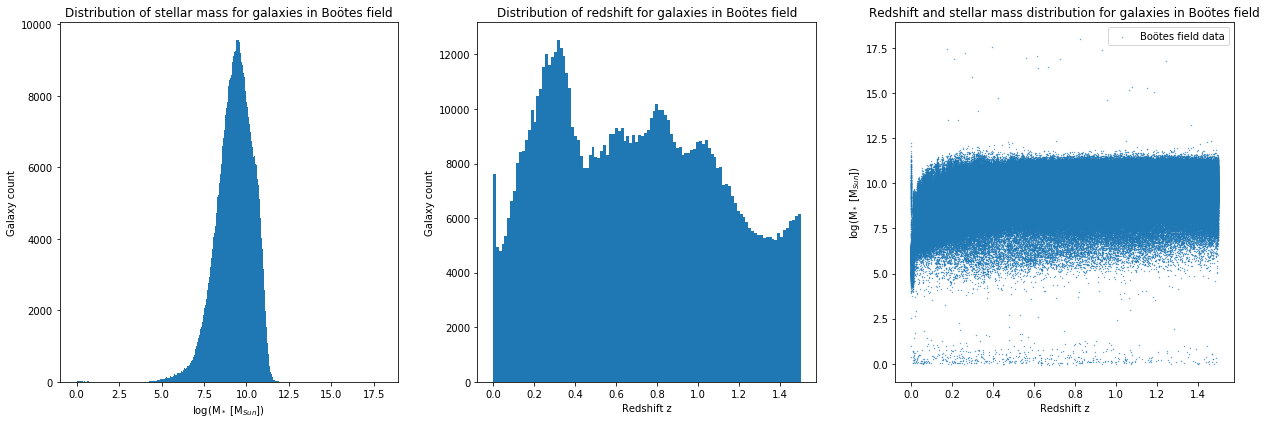

In [4]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
# Plotting stellar mass histogram
ax[0].set_title('Distribution of stellar mass for galaxies in Boötes field')
ax[0].set_xlabel('log(M$_*$ [M$_{Sun}$])')
ax[0].set_ylabel('Galaxy count')
ax[0].hist(bootes_data['Mass_median'], 'auto')
# Plotting redshift histogram
ax[1].set_title('Distribution of redshift for galaxies in Boötes field')
ax[1].set_xlabel('Redshift z')
ax[1].set_ylabel('Galaxy count')
ax[1].hist(bootes_data['Z_BEST'], 'auto')
# Plotting Stellar mass vs Redshift
ax[2].set_title('Redshift and stellar mass distribution for galaxies in Boötes field')
ax[2].set_xlabel("Redshift z",fontsize=10)
ax[2].set_ylabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
ax[2].scatter(bootes_data['Z_BEST'],bootes_data['Mass_median'],s=0.1,label='Boötes field data')
ax[2].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

## Ks magnitude distribution

We can also check the distribution of galaxies according to their flux and magnitude in the Ks band. To obtain the magnitudes in the AB system, we shall create a function to perform the appropriate conversion.

In [5]:
def uJyToAB(fluxuJy):
    '''Converts flux in micro Jansky to AB magnitude, with a zeropoint of ~ 3631 Jansky
    Conversion taken from www.star.bristol.ac.uk/~mbt/stilts/sun256/uk.ac.starlink.ttools.func.Fluxes.html'''
    return 2.5*(23+6-np.log10(fluxuJy))-48.6

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
# Plotting Ks flux histogram
ax[0].set_title('Distribution of $K_s$ flux for galaxies in Boötes field')
ax[0].set_xlabel('$K_s$ flux [micro Jansky]')
ax[0].set_ylabel('Galaxy count')
ax[0].set_yscale('log')
ax[0].hist(bootes_data['Ks_flux'], 'auto')
# Plotting Ks magnitude vs Redshift
ax[1].set_title('Redshift and $K_s$ magnitude distribution for galaxies in Boötes field')
ax[1].set_xlabel("Redshift z",fontsize=10)
ax[1].set_ylabel("$K_s$ [mag]",fontsize=10)
ax[1].scatter(bootes_data['Z_BEST'],uJyToAB(bootes_data['Ks_flux']),s=0.1,label='Boötes field data')
ax[1].axhline(24,color='0.5',linewidth=1)
ax[1].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

Following the sample specifications of Ilbert et al. 2013 and Man et al. 2016, we will limit our sample to those galaxies with Ks < 24.

In [7]:
# Making cut in Ks magnitude
bootes_data = bootes_data[uJyToAB(bootes_data['Ks_flux'])<24]
print(f"Number of galaxies in sample: {len(bootes_data)}")

Number of galaxies in sample: 792856


## Exploring color-color space

By choosing three rest-frame bands (for example, u, R and J), we can define two colors which we will use to select galaxies as quiescent or star-forming. In order to have easy acces to these colors for later operations, we will add two new columns to the table based on the values of other columns.

In [8]:
filter1 = 'u'
filter2 = 'R'
filter3 = 'J'
bootes_data['u-R']=bootes_data[f'{filter1}_rest']-bootes_data[f'{filter2}_rest']
bootes_data['R-J']=bootes_data[f'{filter2}_rest']-bootes_data[f'{filter3}_rest']

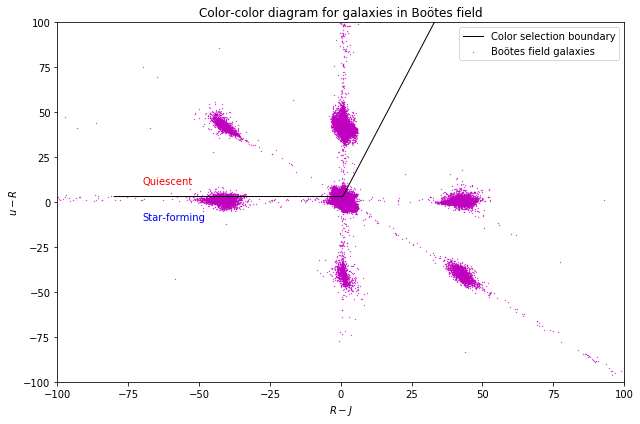

In [9]:
fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.set_title('Color-color diagram for galaxies in Boötes field')
ax1.set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
ax1.set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
ax1.scatter(bootes_data['R-J'],bootes_data['u-R'],color='m',s=0.1,label='Boötes field galaxies')
ax1.plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
ax1.legend(numpoints=1, loc='best')
ax1.set_xlim(xmin=-100,xmax=100)
ax1.set_ylim(ymin=-100,ymax=100)
ax1.annotate('Quiescent',xy=(0,0),xytext=(-70,10),fontsize=10,color='r')
ax1.annotate('Star-forming',xy=(0,0),xytext=(-70,-10),fontsize=10,color='b')
fig1.tight_layout()
plt.show()

We see that there is a large spread in the distribution of galaxies in this color-color space. We will now restrict our sample to the galaxies within the central region of this plane.

In [10]:
bootes_data = bootes_data[
    (bootes_data['u-R']>=-6) &
    (bootes_data['u-R']<=10) &
    (bootes_data['R-J']>=-5) &
    (bootes_data['R-J']<=6.5)]

We can calculate the fraction of galaxies within the 'quiescent region', and the fraction of those that have viable data at 24 micron from MIPS.

In [11]:
final_sample=len(bootes_data)
quiescent = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1))
star_forming = np.count_nonzero(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))
print(f"Number of galaxies in sample: {final_sample}")
print(f"Number of quiescent galaxies in the sample: {quiescent}")
q_mass = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['Mass_median'])))
print(f"Fraction of quiescent galaxies with stellar mass data: {q_mass/quiescent:.2%}")
q_MIPS = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_MIPS_24'])))
print(f"Fraction of quiescent galaxies with MIPS data: {q_MIPS/quiescent:.2%}")
q_MIPSgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_MIPS_24']>0))
print(f"Fraction of quiescent galaxies with MIPS flux > 0 uJy: {q_MIPSgt0/quiescent:.2%}")
q_MIPSgt80 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_MIPS_24']>80))
print(f"Fraction of quiescent galaxies with MIPS flux > 80 uJy: {q_MIPSgt80/quiescent:.2%}")

print(f"Number of star-forming galaxies in the sample: {star_forming}")
sf_mass = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['Mass_median'])))
print(f"Fraction of star forming galaxies with stellar mass data: {sf_mass/star_forming:.2%}")
sf_MIPS = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_MIPS_24'])))
print(f"Fraction of star forming galaxies with MIPS data: {sf_MIPS/star_forming:.2%}")
sf_MIPSgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_MIPS_24']>0))
print(f"Fraction of star forming galaxies with MIPS flux > 0 uJy: {sf_MIPSgt0/star_forming:.2%}")
sf_MIPSgt80 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_MIPS_24']>80))
print(f"Fraction of star forming galaxies with MIPS flux > 80 uJy: {sf_MIPSgt80/star_forming:.2%}")

Number of galaxies in sample: 753690
Number of quiescent galaxies in the sample: 9973
Fraction of quiescent galaxies with stellar mass data: 89.98%
Fraction of quiescent galaxies with MIPS data: 76.92%
Fraction of quiescent galaxies with MIPS flux > 0 uJy: 60.30%
Fraction of quiescent galaxies with MIPS flux > 80 uJy: 14.33%
Number of star-forming galaxies in the sample: 743717
Fraction of star forming galaxies with stellar mass data: 91.47%
Fraction of star forming galaxies with MIPS data: 77.09%
Fraction of star forming galaxies with MIPS flux > 0 uJy: 55.28%
Fraction of star forming galaxies with MIPS flux > 80 uJy: 12.38%


Seeing that our sub-samples have large fractions with stellar mass data, we will now restrict the sample to only include those galaxies.

In [13]:
bootes_data = bootes_data[np.isfinite(bootes_data['Mass_median'])]
final_sample=len(bootes_data)
quiescent = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1))
star_forming = np.count_nonzero(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))
print(f"Number of galaxies in sample: {final_sample}")
print(f"Number of quiescent galaxies in the sample: {quiescent}")
q_mass = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['Mass_median'])))
print(f"Fraction of quiescent galaxies with stellar mass data: {q_mass/quiescent:.2%}")
q_MIPS = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_MIPS_24'])))
print(f"Fraction of quiescent galaxies with MIPS data: {q_MIPS/quiescent:.2%}")
q_MIPSgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_MIPS_24']>0))
print(f"Fraction of quiescent galaxies with MIPS flux > 0 uJy: {q_MIPSgt0/quiescent:.2%}")
q_MIPSgt80 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_MIPS_24']>80))
print(f"Fraction of quiescent galaxies with MIPS flux > 80 uJy: {q_MIPSgt80/quiescent:.2%}")

print(f"Number of star-forming galaxies in the sample: {star_forming}")
sf_mass = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['Mass_median'])))
print(f"Fraction of star forming galaxies with stellar mass data: {sf_mass/star_forming:.2%}")
sf_MIPS = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_MIPS_24'])))
print(f"Fraction of star forming galaxies with MIPS data: {sf_MIPS/star_forming:.2%}")
sf_MIPSgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_MIPS_24']>0))
print(f"Fraction of star forming galaxies with MIPS flux > 0 uJy: {sf_MIPSgt0/star_forming:.2%}")
sf_MIPSgt80 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_MIPS_24']>80))
print(f"Fraction of star forming galaxies with MIPS flux > 80 uJy: {sf_MIPSgt80/star_forming:.2%}")

Number of galaxies in sample: 689241
Number of quiescent galaxies in the sample: 8974
Fraction of quiescent galaxies with stellar mass data: 100.00%
Fraction of quiescent galaxies with MIPS data: 76.94%
Fraction of quiescent galaxies with MIPS flux > 0 uJy: 59.93%
Fraction of quiescent galaxies with MIPS flux > 80 uJy: 13.75%
Number of star-forming galaxies in the sample: 680267
Fraction of star forming galaxies with stellar mass data: 100.00%
Fraction of star forming galaxies with MIPS data: 77.25%
Fraction of star forming galaxies with MIPS flux > 0 uJy: 54.57%
Fraction of star forming galaxies with MIPS flux > 80 uJy: 11.88%


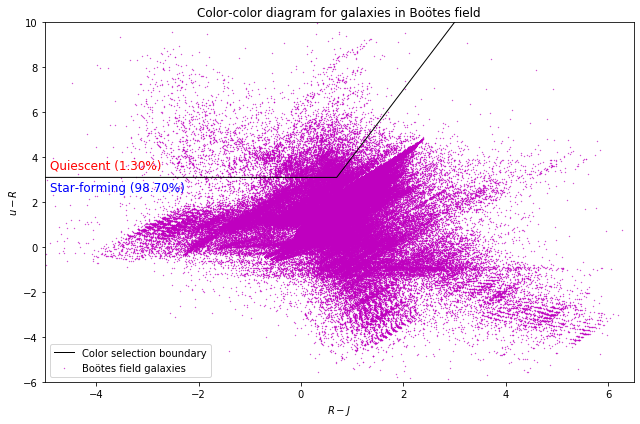

In [14]:
fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.set_title('Color-color diagram for galaxies in Boötes field')
ax1.set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
ax1.set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
ax1.scatter(bootes_data['R-J'],bootes_data['u-R'],color='m',s=0.1,label='Boötes field galaxies')
#xmin = min(bootes_data[f'{filter2}_rest']-bootes_data[f'{filter3}_rest'])
#xmax = max(bootes_data[f'{filter2}_rest']-bootes_data[f'{filter3}_rest'])
ax1.plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
ax1.legend(numpoints=1, loc='best')
ax1.set_xlim(xmin=-5,xmax=6.5)
ax1.set_ylim(ymin=-6,ymax=10)
ax1.annotate(f"Quiescent ({quiescent/final_sample:.2%})",xy=(0,0),xytext=(-4.9,3.5),fontsize=12,color='r')
ax1.annotate(f"Star-forming ({star_forming/final_sample:.2%})",xy=(0,0),xytext=(-4.9,2.5),fontsize=12,color='b')
fig1.tight_layout()
plt.show()

Finally, we can take a look at the redshift and stellar mass distributions of our narrowed down sample.

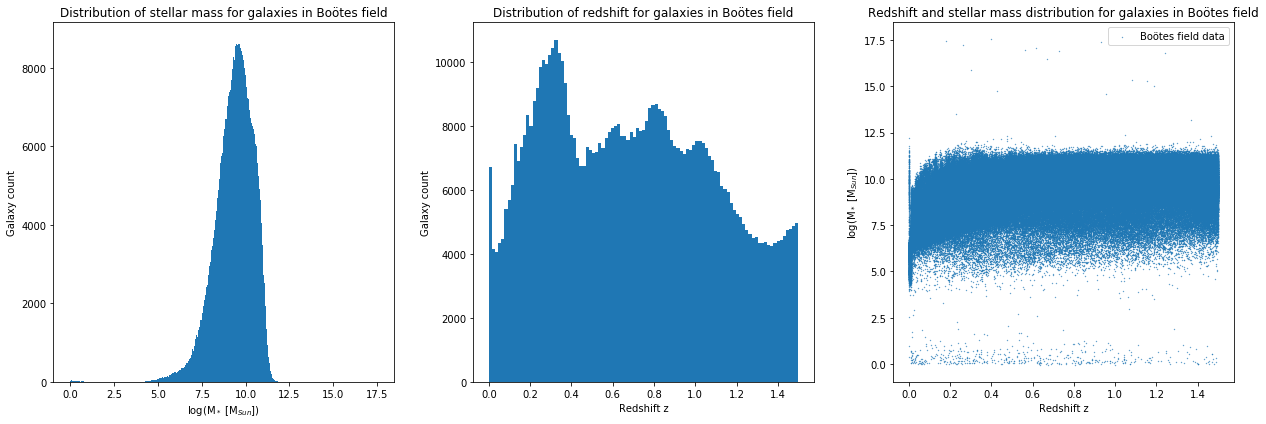

In [15]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
# Plotting stellar mass histogram
ax[0].set_title('Distribution of stellar mass for galaxies in Boötes field')
ax[0].set_xlabel('log(M$_*$ [M$_{Sun}$])')
ax[0].set_ylabel('Galaxy count')
ax[0].hist(bootes_data['Mass_median'], 'auto')
# Plotting redshift histogram
ax[1].set_title('Distribution of redshift for galaxies in Boötes field')
ax[1].set_xlabel('Redshift z')
ax[1].set_ylabel('Galaxy count')
ax[1].hist(bootes_data['Z_BEST'], 'auto')
# Plotting Stellar mass vs Redshift
ax[2].set_title('Redshift and stellar mass distribution for galaxies in Boötes field')
ax[2].set_xlabel("Redshift z",fontsize=10)
ax[2].set_ylabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
ax[2].scatter(bootes_data['Z_BEST'],bootes_data['Mass_median'],s=0.1,label='Boötes field data')
ax[2].legend(numpoints=1, loc='best')
fig.tight_layout()
plt.show()

In [14]:
end_time=time.time()
print("Pandas dataframe took {:.4g} seconds!".format(end_time-start_time))

Pandas dataframe took 24.3 seconds!


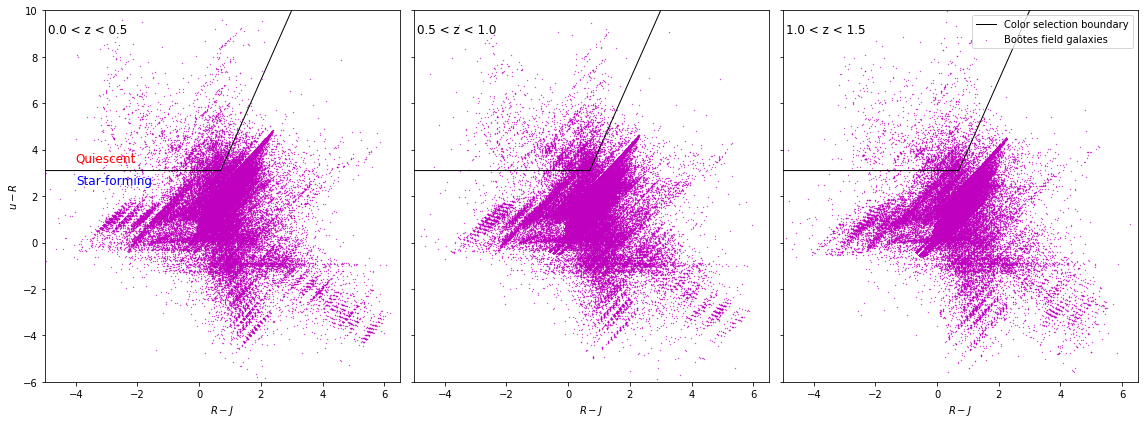

In [16]:
fig1, ax1 = plt.subplots(1,3,sharey='row',figsize=(16,6))
#fig1.suptitle('Color-color diagrams for different redshift bins')
fig1.subplots_adjust(wspace=0)
#fig1.subplots_adjust(hspace=1)
for n, zmin, zmax in zip([0,1,2],[0.0,0.5,1.0],[0.5,1.0,1.5]):
    ax1[n].set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
    xdata = bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax),'R-J']
    ydata = bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax),'u-R']
    ax1[n].scatter(xdata,ydata,color='m',s=0.1,label='Boötes field galaxies')
    ax1[n].plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
    ax1[n].set_xlim(xmin=-5,xmax=6.5)
    ax1[n].set_ylim(ymin=-6,ymax=10)
    ax1[n].annotate(f"{zmin} < z < {zmax}",xy=(0,0),xytext=(-4.9,9),fontsize=12,color='k')
ax1[0].set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
ax1[2].legend(numpoints=1, loc='best')
ax1[0].annotate('Quiescent',xy=(0,0),xytext=(-4,3.5),fontsize=12,color='r')
ax1[0].annotate('Star-forming',xy=(0,0),xytext=(-4,2.5),fontsize=12,color='b')
fig1.tight_layout()
plt.show()

## Estimating SFRs from MIPS 24 micron flux

In [17]:
from scipy import interpolate
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

z = np.array([0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8])
Az = np.array([2.656,2.35,2.06,2.012,1.659,1.296,1.137,1.039,1.015,0.934,0.922,0.896,0.837,0.768,0.655])
Bz = np.array([0.975,1.02,1.056,1.065,1.094,1.129,1.159,1.179,1.165,1.149,1.145,1.149,1.158,1.175,1.198])
Az_intrp = interpolate.interp1d(z, Az, kind='cubic')
Bz_intrp = interpolate.interp1d(z, Bz, kind='cubic')

In [18]:
def F24_to_LIR(flux, zobj):
    '''Convert Spitzer/MIPS 24 micron flux and redshift to total IR
    luminosity according to Rujopakarn et al. (2013)    
    Input: flux in microJy, redshift
    Output: LIR in Lsun
    '''
    if (np.isnan(flux))|(zobj==0):
        return np.nan
    elif flux>0:
        Mpc_to_cm = 3.08568025*(10**24) # 1 Mpc in cm
        microJy_to_Jy = 10**(-6)        # 1 mJy in Jy
        D_L = cosmo.luminosity_distance(zobj).value*Mpc_to_cm # Luminosity distance in cm
        
        logLIR = Az_intrp(zobj) + Bz_intrp(zobj)*(np.log10(flux*microJy_to_Jy*4*np.pi*(D_L**2)) - 45)
        return 10**logLIR
    else:
        return np.nan

def LIR_to_SFR(LIR):
    '''Convert LIR to SFR
    Input: LIR in Lsun
    Output: SFR in Msun/yr (Kroupa 2002 IMF)
    NOTE: This conversion is calibrated for LIR > 5*10^9, if given a lower value it will return an extrapolation
    '''
    L24 = 10**((np.log10(LIR) - 1.096)/0.982)
    
    if (LIR < 1.3*10**12):
        SFR = L24*7.8*10**(-10)
    else:
        SFR = (L24*7.8*10**(-10))*(L24*6.2*10**(-12))**0.048
    return SFR

In [19]:
bootes_data['LIR_24'] = pd.Series([F24_to_LIR(flux,zobj) for flux, zobj in zip(bootes_data['F_MIPS_24'],bootes_data['Z_BEST'])])

bootes_data['SFR_24'] = pd.Series([LIR_to_SFR(LIR) for LIR in bootes_data['LIR_24']])

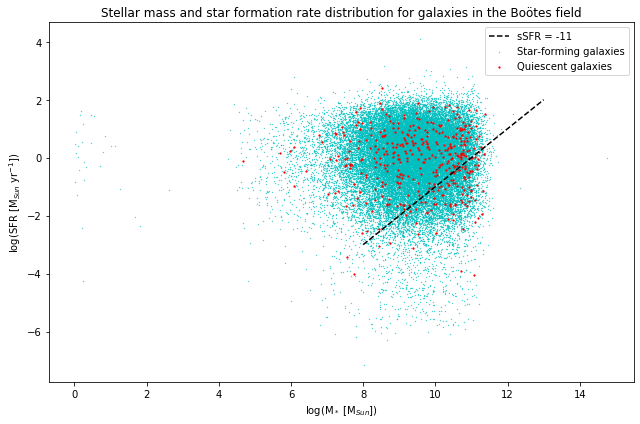

In [32]:
#%% Plotting Star formation rate vs Stellar mass
fig3, ax3 = plt.subplots(figsize=(9,6))
ax3.set_title('Stellar mass and star formation rate distribution for galaxies in the Boötes field')
ax3.set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
ax3.set_ylabel("log(SFR [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
ax3.scatter(bootes_data.loc[~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1),'Mass_median'],
            np.log10(bootes_data.loc[~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1),'SFR_24']),
            s=0.1,color='c',label='Star-forming galaxies')
#star_forming = np.count_nonzero(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))
ax3.scatter(bootes_data.loc[(bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1),'Mass_median'],
            np.log10(bootes_data.loc[(bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1),'SFR_24']),
            s=1.5,color='r',label='Quiescent galaxies')
#quiescent = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1))
ax3.plot([8,13],[-3,2],'--',color='k',label='sSFR = -11')
#ax3.set_xlim(xmin=10.7,xmax=13)
#ax3.set_ylim(ymin=-3,ymax=7)
ax3.legend(numpoints=1, loc='best')
fig3.tight_layout()
plt.show()

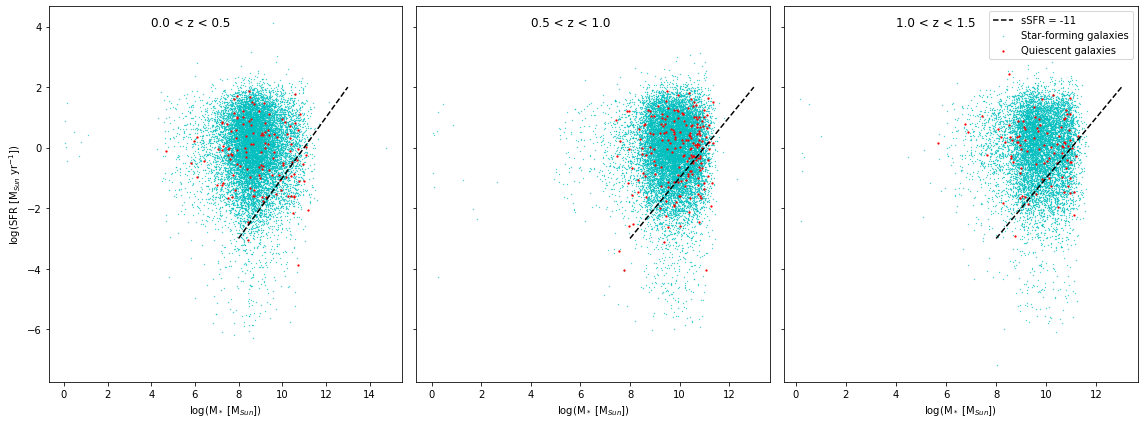

In [34]:
fig1, ax1 = plt.subplots(1,3,sharey='row',figsize=(16,6))
#fig1.suptitle('Stellar mass vs SFR for different redshift bins')
fig1.subplots_adjust(wspace=0)
#fig1.subplots_adjust(hspace=1)
for n, zmin, zmax in zip([0,1,2],[0.0,0.5,1.0],[0.5,1.0,1.5]):
    ax1[n].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
    ax1[n].scatter(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1)),'Mass_median'],
                   np.log10(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1)),'SFR_24']),
                   s=0.1,color='c',label='Star-forming galaxies')
    #star_forming = np.count_nonzero(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))
    ax1[n].scatter(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1),'Mass_median'],
                   np.log10(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1),'SFR_24']),
                   s=1.5,color='r',label='Quiescent galaxies')
    #quiescent = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1))
    ax1[n].plot([8,13],[-3,2],'--',color='k',label='sSFR = -11')
    #ax1[n].set_xlim(xmin=10.7,xmax=13)
    #ax1[n].set_ylim(ymin=-3,ymax=7)
    ax1[n].annotate(f"{zmin} < z < {zmax}",xy=(11,2),xytext=(4,4),fontsize=12,color='k')
    
ax1[0].set_ylabel("log(SFR [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
ax1[2].legend(numpoints=1, loc='best')
fig1.tight_layout()
plt.show()

In [36]:
q_PACS = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_PACS_100'])))
print(f"Fraction of quiescent galaxies with PACS 100 data: {q_PACS/quiescent:.2%}")
q_PACSgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_PACS_100']>0))
print(f"Fraction of quiescent galaxies with PACS 100 flux > 0 uJy: {q_PACSgt0/quiescent:.2%}")
sf_PACS = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_PACS_100'])))
print(f"Fraction of star forming galaxies with PACS 100 data: {sf_PACS/star_forming:.2%}")
sf_PACSgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_PACS_100']>0))
print(f"Fraction of star forming galaxies with PACS 100 flux > 0 uJy: {sf_PACSgt0/star_forming:.2%}")

q_PACS = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_PACS_160'])))
print(f"Fraction of quiescent galaxies with PACS 160 data: {q_PACS/quiescent:.2%}")
q_PACSgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_PACS_160']>0))
print(f"Fraction of quiescent galaxies with PACS 160 flux > 0 uJy: {q_PACSgt0/quiescent:.2%}")
sf_PACS = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_PACS_160'])))
print(f"Fraction of star forming galaxies with PACS 160 data: {sf_PACS/star_forming:.2%}")
sf_PACSgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_PACS_160']>0))
print(f"Fraction of star forming galaxies with PACS 160 flux > 0 uJy: {sf_PACSgt0/star_forming:.2%}")

q_SPIRE = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_SPIRE_250'])))
print(f"Fraction of quiescent galaxies with SPIRE 250 data: {q_SPIRE/quiescent:.2%}")
q_SPIREgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_SPIRE_250']>0))
print(f"Fraction of quiescent galaxies with SPIRE 250 flux > 0 uJy: {q_SPIREgt0/quiescent:.2%}")
sf_SPIRE = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_SPIRE_250'])))
print(f"Fraction of star forming galaxies with SPIRE 250 data: {sf_SPIRE/star_forming:.2%}")
sf_SPIREgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_SPIRE_250']>0))
print(f"Fraction of star forming galaxies with SPIRE 250 flux > 0 uJy: {sf_SPIREgt0/star_forming:.2%}")

q_SPIRE = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_SPIRE_350'])))
print(f"Fraction of quiescent galaxies with SPIRE 350 data: {q_SPIRE/quiescent:.2%}")
q_SPIREgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_SPIRE_350']>0))
print(f"Fraction of quiescent galaxies with SPIRE 350 flux > 0 uJy: {q_SPIREgt0/quiescent:.2%}")
sf_SPIRE = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_SPIRE_350'])))
print(f"Fraction of star forming galaxies with SPIRE 350 data: {sf_SPIRE/star_forming:.2%}")
sf_SPIREgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_SPIRE_350']>0))
print(f"Fraction of star forming galaxies with SPIRE 350 flux > 0 uJy: {sf_SPIREgt0/star_forming:.2%}")

q_SPIRE = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_SPIRE_500'])))
print(f"Fraction of quiescent galaxies with SPIRE 500 data: {q_SPIRE/quiescent:.2%}")
q_SPIREgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_SPIRE_500']>0))
print(f"Fraction of quiescent galaxies with SPIRE 500 flux > 0 uJy: {q_SPIREgt0/quiescent:.2%}")
sf_SPIRE = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_SPIRE_500'])))
print(f"Fraction of star forming galaxies with SPIRE 500 data: {sf_SPIRE/star_forming:.2%}")
sf_SPIREgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_SPIRE_500']>0))
print(f"Fraction of star forming galaxies with SPIRE 500 flux > 0 uJy: {sf_SPIREgt0/star_forming:.2%}")

Fraction of quiescent galaxies with PACS 100 data: 32.94%
Fraction of quiescent galaxies with PACS 100 flux > 0 uJy: 32.94%
Fraction of star forming galaxies with PACS 100 data: 28.98%
Fraction of star forming galaxies with PACS 100 flux > 0 uJy: 28.98%
Fraction of quiescent galaxies with PACS 160 data: 32.94%
Fraction of quiescent galaxies with PACS 160 flux > 0 uJy: 32.94%
Fraction of star forming galaxies with PACS 160 data: 28.98%
Fraction of star forming galaxies with PACS 160 flux > 0 uJy: 28.98%
Fraction of quiescent galaxies with SPIRE 250 data: 33.75%
Fraction of quiescent galaxies with SPIRE 250 flux > 0 uJy: 33.75%
Fraction of star forming galaxies with SPIRE 250 data: 30.11%
Fraction of star forming galaxies with SPIRE 250 flux > 0 uJy: 30.11%
Fraction of quiescent galaxies with SPIRE 350 data: 33.75%
Fraction of quiescent galaxies with SPIRE 350 flux > 0 uJy: 33.75%
Fraction of star forming galaxies with SPIRE 350 data: 30.11%
Fraction of star forming galaxies with SPIRE 3

In [26]:
print(f"Galaxies with z=0: {np.count_nonzero(bootes_data['Z_BEST']==0)}")
print(f"Galaxies with z<0.1: {np.count_nonzero(bootes_data['Z_BEST']<0.1)}")

Galaxies with z=0: 393
Galaxies with z<0.1: 32490


In [37]:
bootes_data = bootes_data[bootes_data['Z_BEST']>=0.1]
final_sample=len(bootes_data)
quiescent = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1))
star_forming = np.count_nonzero(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))
print(f"Number of galaxies in sample: {final_sample}")
print(f"Number of quiescent galaxies in the sample: {quiescent}")
q_MIPS = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(np.isfinite(bootes_data['F_MIPS_24'])))
print(f"Fraction of quiescent galaxies with MIPS data: {q_MIPS/quiescent:.2%}")
q_MIPSgt0 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_MIPS_24']>0))
print(f"Fraction of quiescent galaxies with MIPS flux > 0 uJy: {q_MIPSgt0/quiescent:.2%}")
q_MIPSgt80 = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1)&(bootes_data['F_MIPS_24']>80))
print(f"Fraction of quiescent galaxies with MIPS flux > 80 uJy: {q_MIPSgt80/quiescent:.2%}")

print(f"Number of star-forming galaxies in the sample: {star_forming}")
sf_MIPS = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(np.isfinite(bootes_data['F_MIPS_24'])))
print(f"Fraction of star forming galaxies with MIPS data: {sf_MIPS/star_forming:.2%}")
sf_MIPSgt0 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_MIPS_24']>0))
print(f"Fraction of star forming galaxies with MIPS flux > 0 uJy: {sf_MIPSgt0/star_forming:.2%}")
sf_MIPSgt80 = np.count_nonzero((~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))&(bootes_data['F_MIPS_24']>80))
print(f"Fraction of star forming galaxies with MIPS flux > 80 uJy: {sf_MIPSgt80/star_forming:.2%}")

Number of galaxies in sample: 656751
Number of quiescent galaxies in the sample: 8695
Fraction of quiescent galaxies with MIPS data: 77.07%
Fraction of quiescent galaxies with MIPS flux > 0 uJy: 60.13%
Fraction of quiescent galaxies with MIPS flux > 80 uJy: 14.02%
Number of star-forming galaxies in the sample: 648056
Fraction of star forming galaxies with MIPS data: 77.41%
Fraction of star forming galaxies with MIPS flux > 0 uJy: 54.68%
Fraction of star forming galaxies with MIPS flux > 80 uJy: 12.26%


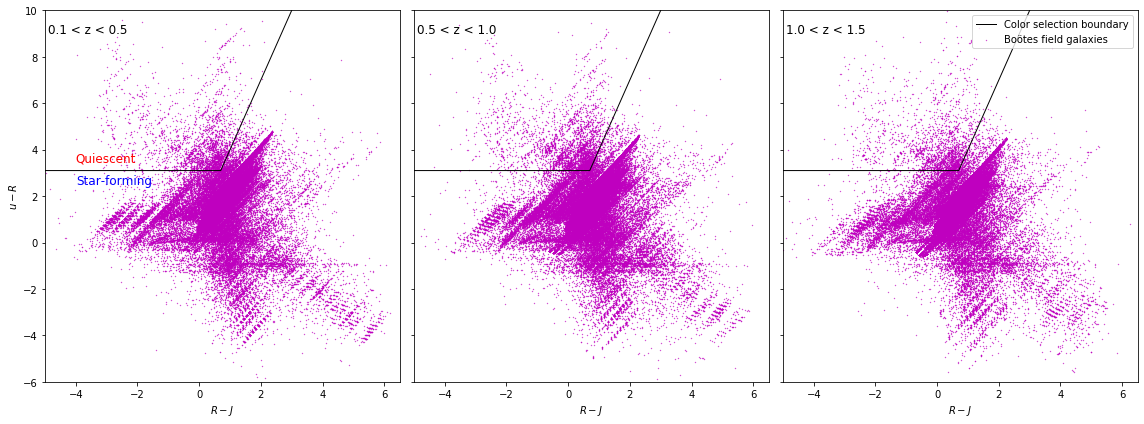

In [38]:
fig1, ax1 = plt.subplots(1,3,sharey='row',figsize=(16,6))
#fig1.suptitle('Color-color diagrams for different redshift bins')
fig1.subplots_adjust(wspace=0)
#fig1.subplots_adjust(hspace=1)
for n, zmin, zmax in zip([0,1,2],[0.1,0.5,1.0],[0.5,1.0,1.5]):
    ax1[n].set_xlabel(f"${filter2}-{filter3}$",fontsize=10)
    xdata = bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax),'R-J']
    ydata = bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax),'u-R']
    ax1[n].scatter(xdata,ydata,color='m',s=0.1,label='Boötes field galaxies')
    ax1[n].plot([-80,0.7,80],[3.1,3.1,241],color='k',linewidth=1,label='Color selection boundary')
    ax1[n].set_xlim(xmin=-5,xmax=6.5)
    ax1[n].set_ylim(ymin=-6,ymax=10)
    ax1[n].annotate(f"{zmin} < z < {zmax}",xy=(0,0),xytext=(-4.9,9),fontsize=12,color='k')
ax1[0].set_ylabel(f"${filter1}-{filter2}$",fontsize=10)
ax1[2].legend(numpoints=1, loc='best')
ax1[0].annotate('Quiescent',xy=(0,0),xytext=(-4,3.5),fontsize=12,color='r')
ax1[0].annotate('Star-forming',xy=(0,0),xytext=(-4,2.5),fontsize=12,color='b')
fig1.tight_layout()
plt.show()

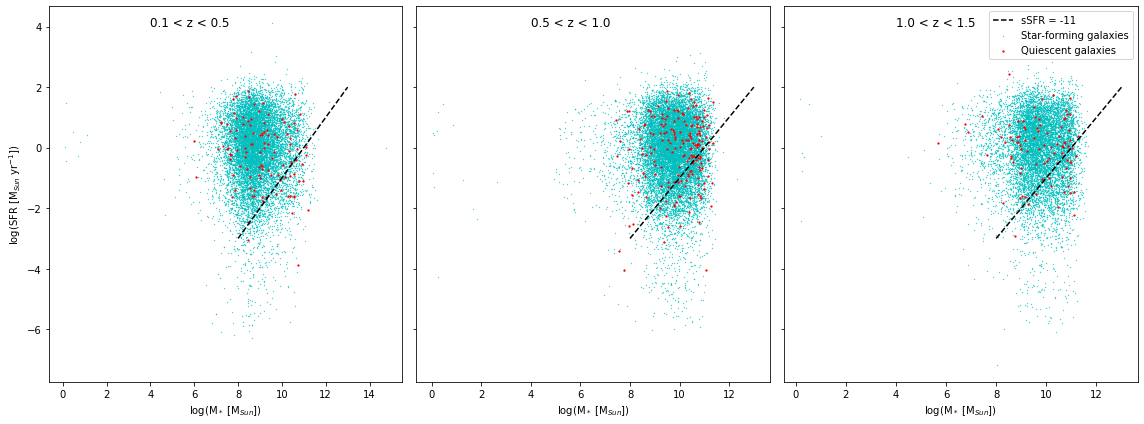

In [39]:
fig1, ax1 = plt.subplots(1,3,sharey='row',figsize=(16,6))
#fig1.suptitle('Stellar mass vs SFR for different redshift bins')
fig1.subplots_adjust(wspace=0)
#fig1.subplots_adjust(hspace=1)
for n, zmin, zmax in zip([0,1,2],[0.1,0.5,1.0],[0.5,1.0,1.5]):
    ax1[n].set_xlabel("log(M$_*$ [M$_{Sun}$])",fontsize=10)
    ax1[n].scatter(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1)),'Mass_median'],
                   np.log10(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1)),'SFR_24']),
                   s=0.1,color='c',label='Star-forming galaxies')
    #star_forming = np.count_nonzero(~(bootes_data['u-R']>3.1)|~(bootes_data['u-R']>3*bootes_data['R-J']+1))
    ax1[n].scatter(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1),'Mass_median'],
                   np.log10(bootes_data.loc[(bootes_data['Z_BEST']>=zmin)&(bootes_data['Z_BEST']<zmax)&(bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1),'SFR_24']),
                   s=1.5,color='r',label='Quiescent galaxies')
    #quiescent = np.count_nonzero((bootes_data['u-R']>3.1)&(bootes_data['u-R']>3*bootes_data['R-J']+1))
    ax1[n].plot([8,13],[-3,2],'--',color='k',label='sSFR = -11')
    #ax1[n].set_xlim(xmin=10.7,xmax=13)
    #ax1[n].set_ylim(ymin=-3,ymax=7)
    ax1[n].annotate(f"{zmin} < z < {zmax}",xy=(11,2),xytext=(4,4),fontsize=12,color='k')
    
ax1[0].set_ylabel("log(SFR [M$_{Sun}$ yr$^{-1}$])",fontsize=10)
ax1[2].legend(numpoints=1, loc='best')
fig1.tight_layout()
plt.show()